In [12]:
!pip install scikit-learn umap-learn fuzzy-c-means pandas numpy matplotlib seaborn ipywidgets mlxtend tqdm -q

In [13]:
# Importing plotting libraries
import matplotlib.pyplot as plt  # For Creating static, interactive, and animated visualizations
import seaborn as sns            # For Making statistical graphics and visualization

# Importing the tqdm library to display progress bars during iterations
from tqdm import tqdm

# Importing the datetime module to retrieve and format the current time
import datetime

# Importing dimensionality reduction and clustering libraries
import umap                      # For Uniform Manifold Approximation and Projection (UMAP)
import pandas as pd              # For Data manipulation and analysis
import numpy as np               # For Numerical operations on arrays
from fcmeans import FCM          # For Fuzzy Clustering and membership functions

# Importing preprocessing and evaluation metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, OneHotEncoder     # For Feature scaling and processing
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score                   # For Clustering evaluation metrics
from sklearn.model_selection import ParameterGrid                                                             # For Generating parameter combinations

# Importing dimensionality reduction techniques
from sklearn.decomposition import PCA, TruncatedSVD  # For Principal Component Analysis and Singular Value Decomposition

# Importing clustering algorithms
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift  # For Various clustering methods
from kmodes.kprototypes import KPrototypes                                      # For Categorical clustering methods
from kmodes.kmodes import KModes                                                # For Categorical clustering methods

# Importing manifold learning techniques
from sklearn.manifold import TSNE  # For t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction

# Importing a utility for creating synthetic data
from sklearn.datasets import make_blobs  # For Generating synthetic datasets with blob structure

In [14]:
class ClusteringModel:
    def __init__(self,
                 X_input,
                 random_state=42,
                 verbose=1,
                 exclude_dict=None,
                 numerical_dict_params=None,
                 categorical_dict_params=None,
                 n_jobs=-1,
                 use_categorical=False,
                 categorical_cols=None
                 ):
        """
        Initialize the ClusteringModel with raw data, optional verbosity, and exclusions.

        Parameters:
        - X_input: The raw input data.
        - random_state: Random seed for reproducibility.
        - verbose: Verbosity level.
        - exclude_dict: Dictionary to exclude certain scalers, reducers, or models.
        - numerical_dict_params: Dictionary of parameters for models.
        - n_jobs: Number of parallel jobs.
        - use_categorical: Whether to use categorical models or not.
        - categorical_cols: List of indices of categorical columns if use_categorical is True.
        """
        self.X_input = X_input
        self.exclude_dict = exclude_dict if exclude_dict else {}
        
        if not isinstance(self.X_input, np.ndarray):
            raise ValueError("[ERROR]: The input must be a NumPy array.")

        self.scalers = {
            'MinMaxScaler': MinMaxScaler(),
            'StandardScaler': StandardScaler(),
            'RobustScaler': RobustScaler()
        }
        self.reducers = {
            'PCA': PCA,
            'UMAP': umap.UMAP,
            'SVD': TruncatedSVD
        }
        
        self.use_categorical = use_categorical
        self.categorical_cols = categorical_cols
        
        self.metrics_one_hot_encoder = OneHotEncoder()
        self.metrics_scaler = MaxAbsScaler()
        
        if self.use_categorical:
            exclude_dict = {
                'scalers': ['MinMaxScaler', 'StandardScaler', 'RobustScaler'],
                'reducers': ['PCA', 'UMAP', 'SVD'],
            }
        if not self.use_categorical:
            self.X_input_scaled = {
                                            name: scaler.fit_transform(X_input) 
                                            for name, scaler in self.scalers.items() 
                                            if name not in self.exclude_dict.get('scalers', [])
                                        }
        else:
            self.X_input_scaled_processed = self.preprocess_categorical(X_input)
        self.reduced_tensor = {}
        
        if self.use_categorical and not self.categorical_cols:
            raise ValueError("If `use_categorical` is True, the list `categorical_cols` must be provided.")
        
        if not self.use_categorical:
            if numerical_dict_params:
                self.models = numerical_dict_params
            else:
                self.models = {
                    'DBSCAN': {
                        'eps': [round(i * 0.1, 1) for i in range(4, 6)],
                        'min_samples': list(range(16, 16 * 3, 16))
                    },
                    'KMeans': {'n_clusters': list(range(2, 6))},
                    'AgglomerativeClustering': {'n_clusters': list(range(2, 6))},
                    'MeanShift': {'bandwidth': list(range(2, 4))},
                    'FuzzyCMeans': {
                                    'n_clusters': list(range(2, 6)),
                                    'm': list(range(2, 3))
                    }
                }
        else:
            if categorical_dict_params:
                self.models = categorical_dict_params
            else:
                self.models = {
                    'KModes': {'n_clusters': list(range(2, 6)),
                                    'n_init': [5, 10],
                                    'init': ['Huang', 'Cao']},
                    'KPrototypes': {'n_clusters': list(range(2, 6)),
                                    'n_init': [5, 10],
                                    'init': ['Huang', 'Cao']
                                    }
                }
                
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.best_model = None
        self.best_combination = None
        self.best_scaler = None
        self.best_reducer = None
        self.reduction_df = None
        
        if self.verbose == 2:
            print("-"*70)
            print("Model class initialized")
            print("-"*70)

    def reduce_dimension(self, method='PCA', n_components=2):
        """
        Reduce the dimensionality of the raw tensor using the specified method.
        It is an optional method, for the user, not directly used.

        Parameters:
        - method: The dimensionality reduction method to use ('PCA', 'UMAP', 'SVD').
        - n_components: Number of components for the reduction.

        Returns:
        - A dictionary with the reduced tensors for each scaler.
        """        
        if method not in self.reducers or method in self.exclude_dict.get('reducers', []):
            raise ValueError(f"Unsupported or excluded dimensionality reduction method: {method}")
        
        reducer_cls = self.reducers[method]
        kwargs = {'n_components': n_components}
            
        reducer = reducer_cls(**kwargs)
        
        self.reduced_tensor = {scaler_name: reducer.fit_transform(scaled_data) 
                            for scaler_name, scaled_data in self.X_input_scaled.items()}
        
        if self.verbose==2:
            print("-"*70)
            print("Dimension reduction applied")
            
        return self.reduced_tensor

    def fit_models(self, use_reduction=True, use_scalers=True, n_dim=2):
        import warnings
        warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.")

        scalers_to_use = [(name, scaler) for name, scaler in self.scalers.items() if name not in self.exclude_dict.get('scalers', [])] if use_scalers else [('None', self.X_input)]
        reducers_to_use = [(name, cls) for name, cls in self.reducers.items() if name not in self.exclude_dict.get('reducers', [])] if use_reduction else [('None', None)]

        results = []
        
        if self.verbose!=0:
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            print("-"*70)
            print(f"[{current_time}]: Models estimation started.")
            
        if self.verbose!=0:
            print("-"*70)
            progress_bar = tqdm(desc="Processing combinations", unit = " models")   
            
        if not self.use_categorical:                    
            for scaler_name, scaler in scalers_to_use:
                try:
                    if scaler_name != 'None':
                        scaled_data = scaler.fit_transform(self.X_input)
                        tensor_to_use = self.reduced_tensor.get(scaler_name, scaled_data) if use_reduction else scaled_data
                    else:
                        tensor_to_use = self.reduced_tensor.get(scaler_name, self.X_input) if use_reduction else self.X_input

                    for reducer_name, reducer_cls in reducers_to_use:
                        if reducer_name != 'None' and use_reduction:
                            kwargs = {'n_components': n_dim}
                            if reducer_name in ["UMAP", "PCA", "SVD"]:
                                kwargs['random_state'] = self.random_state
                                
                            reducer = reducer_cls(**kwargs)
                            tensor_to_use = reducer.fit_transform(tensor_to_use)

                        for model_name, parameters in self.models.items():
                            if model_name in self.exclude_dict.get('models', []):
                                continue
                            
                            grid = self.generate_combinations(parameters)
                    
                            for combination in grid:
                                if model_name == 'FuzzyCMeans':
                                    model = self._create_model(model_name, combination)
                                    model.fit(tensor_to_use)
                                    labels = model.predict(tensor_to_use)
                                else:
                                    model = self._create_model(model_name, combination)
                                    labels = model.fit_predict(tensor_to_use)

                                n_labels = len(np.unique(labels))

                                if n_labels > 1:
                                    silhouette = silhouette_score(tensor_to_use, labels)
                                    db = davies_bouldin_score(tensor_to_use, labels)
                                    ch = calinski_harabasz_score(tensor_to_use, labels)
                                else:
                                    silhouette = -np.nan
                                    db = np.nan
                                    ch = np.nan

                                results.append({
                                    'scaler': scaler_name,
                                    'reducer': reducer_name,
                                    'model': model_name,
                                    'combination': combination,
                                    'silhouette_score': silhouette,
                                    'davies_bouldin_score': db,
                                    'calinski_harabasz_score': ch,
                                    'groups': n_labels
                                })
                                
                                if self.verbose!=0:
                                    progress_bar.update(1)
                                    
                except:
                    pass
        
        else:                
            tensor_to_use = self.X_input
            
            for model_name, parameters in self.models.items():
                if model_name in self.exclude_dict.get('models', []):
                     continue
                        
                grid = self.generate_combinations(parameters)

                for combination in grid:
                    model = self._create_model(model_name, combination)
    
                    if model_name == "KPrototypes":
                        labels = model.fit_predict(tensor_to_use, categorical=self.categorical_cols)
                        n_labels = len(np.unique(labels))
                    else:
                        labels = model.fit_predict(tensor_to_use)
                        n_labels = len(np.unique(labels))

                    if n_labels > 1:
                        silhouette = silhouette_score(self.X_input_scaled_processed, labels)
                        db = davies_bouldin_score(self.X_input_scaled_processed, labels)
                        ch = calinski_harabasz_score(self.X_input_scaled_processed, labels)
                    else:
                        silhouette = -np.nan
                        db = np.nan
                        ch = np.nan

                    results.append({
                        'scaler': None,
                        'reducer': None,
                        'model': model_name,
                        'combination': combination,
                        'silhouette_score': silhouette,
                        'davies_bouldin_score': db,
                        'calinski_harabasz_score': ch,
                        'groups': n_labels
                    })
                    
                    if self.verbose!=0:
                        progress_bar.update(1) 
                                       
        if self.verbose!=0:
            progress_bar.close()          
        
        if self.verbose!=0:
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            print("-"*70)
            print(f"[{current_time}]: Models estimation finished.")
            
        return results

    @staticmethod
    def generate_combinations(parameters):
        """
        Generate all possible combinations of parameters for grid search.

        Parameters:
        - parameters: A dictionary of parameter names and their possible values.

        Returns:
        - An iterator over the combinations of parameters.
        """
        return ParameterGrid(parameters)

    def _create_model(self, model_name, combination):
        """
        Create a clustering model instance based on the specified model name and parameters.

        Parameters:
        - model_name: The name of the model to create ('DBSCAN', 'KMeans', 'AgglomerativeClustering', 'MeanShift', 'FuzzyCMeans').
        - combination: A dictionary of parameters for the model.

        Returns:
        - An instance of the specified clustering model.

        Raises:
        - ValueError if the model name is unsupported.
        """
        if model_name == 'DBSCAN':
            return DBSCAN(eps=combination['eps'], min_samples=combination['min_samples'], n_jobs=self.n_jobs)
        elif model_name == 'KMeans':
            return KMeans(n_clusters=combination['n_clusters'], random_state=self.random_state)
        elif model_name == 'AgglomerativeClustering':
            return AgglomerativeClustering(n_clusters=combination['n_clusters'])
        elif model_name == 'MeanShift':
            return MeanShift(bandwidth=combination['bandwidth'], n_jobs=self.n_jobs)
        elif model_name == 'FuzzyCMeans':
            return FCM(n_clusters=combination['n_clusters'], m = combination['m'], random_state=self.random_state)
        elif model_name == 'KModes':
            return KModes(n_clusters=combination['n_clusters'], init = combination['init'],
                          n_init = combination['n_init'], random_state=self.random_state)
        elif model_name == 'KPrototypes':
            return KPrototypes(n_clusters=combination['n_clusters'], init = combination['init'],
                               n_init = combination['n_init'], random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def select_best_model(self, metric='clustering_index', use_reduction=True, use_scalers=True, n_min=2, n_max=8):
        """
        Select the best clustering model based on evaluation metrics and specified criteria.

        Parameters:
        - metric (str): The metric to use for selecting the best model. Options:
        'silhouette', 'calinski_harabasz', 'davies_bouldin', or 'clustering_index'.
        - use_reduction (bool): If True, consider dimensionality reduction in model selection.
        - use_scalers (bool): If True, consider scaling in model selection.
        - n_min (int): Minimum number of clusters to consider.
        - n_max (int): Maximum number of clusters to consider.

        Returns:
        - dict: Contains the best model, parameters, scaler, and reducer.
        - pd.DataFrame: DataFrame with the filtered and sorted results.
        """
        
        if self.use_categorical:
            use_reduction=False
            use_scalers=False
        
        # Fit models and store results
        results = self.fit_models(use_reduction=use_reduction, use_scalers=use_scalers)
        df_results = pd.DataFrame(results)
   
        # Filter valid results
        df_filtered = df_results[
            (df_results['groups'].between(n_min, n_max)) &
            (df_results['silhouette_score'] > 0)
        ].reset_index(drop=True)

        if df_filtered.empty:
            raise ValueError("[WARNING]: No valid models found with the given criteria.")

        # Normalize metrics
        df_filtered['silhouette_norm'] = (
            (df_filtered['silhouette_score'] - df_filtered['silhouette_score'].min()) /
            (df_filtered['silhouette_score'].max() - df_filtered['silhouette_score'].min())
        )
        df_filtered['calinski_harabasz_norm'] = (
            (df_filtered['calinski_harabasz_score'] - df_filtered['calinski_harabasz_score'].min()) /
            (df_filtered['calinski_harabasz_score'].max() - df_filtered['calinski_harabasz_score'].min())
        )
        df_filtered['davies_bouldin_inverted'] = (
            df_filtered['davies_bouldin_score'].max() - df_filtered['davies_bouldin_score']
        )
        df_filtered['davies_bouldin_norm'] = (
            (df_filtered['davies_bouldin_inverted'] - df_filtered['davies_bouldin_inverted'].min()) /
            (df_filtered['davies_bouldin_inverted'].max() - df_filtered['davies_bouldin_inverted'].min())
        )

        # Calculate combined clustering index
        df_filtered['clustering_index'] = df_filtered[[
            'silhouette_norm', 'calinski_harabasz_norm', 'davies_bouldin_norm']].mean(axis=1)

        # Drop intermediate columns and round final metrics
        df_filtered.drop(columns=[
            'silhouette_norm', 'calinski_harabasz_norm', 'davies_bouldin_inverted', 'davies_bouldin_norm'], inplace=True)

        final_metrics = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'clustering_index']
        df_filtered[final_metrics] = df_filtered[final_metrics].round(4)

        # Sort results based on the selected metric
        if metric == 'silhouette':
            df_sorted = df_filtered.sort_values(by='silhouette_score', ascending=False)
        elif metric == 'calinski_harabasz':
            df_sorted = df_filtered.sort_values(by='calinski_harabasz_score', ascending=False)
        elif metric == 'davies_bouldin':
            df_sorted = df_filtered.sort_values(by='davies_bouldin_score', ascending=True)
        elif metric == 'clustering_index':
            df_sorted = df_filtered.sort_values(by='clustering_index', ascending=False)
        else:
            raise ValueError(f"Unsupported metric: {metric}")

        df_sorted.reset_index(drop=True, inplace=True)

        # Select the best model
        best_model_row = df_sorted.iloc[0]
        self.best_model = best_model_row['model']
        self.best_combination = best_model_row['combination']
        self.best_scaler = best_model_row['scaler']
        self.best_reducer = best_model_row['reducer']

        # Print verbose information if needed
        if self.verbose == 2:
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            print("-" * 70)
            print(f"[{current_time}]: All the models fitted and best model selected.")
            print("-" * 70)

        # Return the best model details and sorted DataFrame
        return {
            'best_model': self.best_model,
            'best_parameters': self.best_combination,
            'scaler': self.best_scaler,
            'reducer': self.best_reducer
        }, df_sorted


        
    def manual_selection_model(self, df_sorted, n_index):
        """
        Select manually a model based on the metric results.

        Parameters:
        - df_sorted: The pd.DataFrame with the models results.
        - n_index: Integer with the index of the desired model.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        """
        
        best_model_row = df_sorted.iloc[n_index]
        
        best_model = best_model_row['model']
        best_combination = best_model_row['combination']
        best_scaler = best_model_row['scaler']
        best_reducer = best_model_row['reducer']
        
        if self.verbose==2:
            print("-"*70)
            print("Manual model selected.")
            print("-"*70)
            
        return {
            'best_model': best_model,
            'best_parameters': best_combination,
            'scaler': best_scaler,
            'reducer': best_reducer
        }

    def estimate_best_model(self, best_params=None, use_reduction=True, use_scalers=True):
        """
        Estimate the cluster labels using the best selected model.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction using the best reducer.
        - use_scalers: If True, apply scaling using the best scaler.

        Returns:
        - An array of cluster labels for each data point.

        Raises:
        - ValueError if no best model has been selected.
        """
        if best_params != None:
            try:
                self.best_model = best_params['best_model']
                self.best_combination = best_params['best_parameters']
                if best_params['scaler']:
                    self.best_scaler = best_params['scaler']
                if best_params['reducer']:
                    self.best_reducer = best_params['reducer']
            except:
               raise ValueError("[ERROR]: Model introduced was not valid.") 

        if self.best_model is None or self.best_combination is None:
            raise ValueError("[ERROR]: No best model selected. Run select_best_model first.")
        
        if not self.use_categorical:
            if not use_reduction or self.best_reducer == 'None':
                tensor_to_use = self.X_input
            else:
                tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.X_input_scaled.get(self.best_scaler, self.X_input))
                
            if use_scalers and self.best_scaler != 'None':
                tensor_to_use = self.X_input_scaled.get(self.best_scaler, self.X_input)
        else:
            tensor_to_use = self.X_input_scaled_processed
        
        model = self._create_model(self.best_model, self.best_combination)

        if self.best_model == 'FuzzyCMeans':
            model = self._create_model(self.best_model, self.best_combination)
            model.fit(tensor_to_use)
            labels = model.predict(tensor_to_use)
        else:
            labels = model.fit_predict(tensor_to_use)
            
        if self.verbose==2:
            print("-"*70)
            print("Best model estimated.")
            print("-"*70)
            
        return labels
    
    def fit_reduction(self, method='tsne', n_components=2, perplexity=30, learning_rate=200):
        """
        Fit a dimensionality reduction technique (t-SNE, PCA, or SVD) on the data and obtain the embeddings.

        Parameters:
        - method: The reduction method to use ('tsne', 'pca', or 'svd').
        - n_components: Number of dimensions for the reduction.
        - perplexity: Perplexity parameter for t-SNE (ignored if using PCA or SVD).
        - learning_rate: Learning rate parameter for t-SNE (ignored if using PCA or SVD).

        Raises:
        - ValueError if the best model has not been selected yet.
        """
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[WARNING]: Best model has not been selected yet. Please run select_best_model first.")
        
        if not self.use_categorical:
            if self.best_reducer == 'None':
                tensor_to_use = self.X_input
            else:
                tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.X_input_scaled.get(self.best_scaler, self.X_input))
        else:
            tensor_to_use = self.preprocess_categorical(self.X_input, 
                               one_hot_encoding=True, 
                               scaling=True, 
                               dimensionality_reduction=True)
        
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=self.random_state)
            tensor = reducer.fit_transform(tensor_to_use)
            scaler = MinMaxScaler()
            self.reduction_results = scaler.fit_transform(tensor)
            
            if self.verbose != 0:
                print("-"*70)
                print("t-SNE algorithm fitted.")
                print("-"*70)
            
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=self.random_state)
            self.reduction_results = reducer.fit_transform(tensor_to_use)
            scaler = MinMaxScaler()
            self.reduction_results = scaler.fit_transform(tensor)
            if self.verbose != 0:
                print("-"*70)
                print("PCA algorithm fitted.")
                print("-"*70)
        elif method == 'svd':
            reducer = TruncatedSVD(n_components=n_components, random_state=self.random_state)
            self.reduction_results = reducer.fit_transform(tensor_to_use)
            scaler = MinMaxScaler()
            self.reduction_results = scaler.fit_transform(tensor)
            if self.verbose != 0:
                print("-"*70)
                print("SVD algorithm fitted.")
                print("-"*70)
        else:
            raise ValueError(f"[ERROR]: Unsupported reduction method '{method}'. Use 'tsne', 'pca', or 'svd'.")

                
    def plot_reduction(self, labels, method='tsne'):
        """
        Plot the dimensionality reduction results to visualize the clustering in 2D.

        Parameters:
        - labels: Cluster labels for coloring the points.
        - method: The reduction method used ('tsne' or 'pca') for title purposes.

        Raises:
        - ValueError if reduction results or labels are not available. Please run fit_reduction first.
        """
        if self.reduction_results is None or labels is None:
            raise ValueError(f"[WARNING]: {method.upper()} results or labels are not available. Please run fit_reduction first.")
        
        reduction_df = pd.DataFrame(self.reduction_results, columns=['Dimension 1', 'Dimension 2'])
        reduction_df['Cluster'] = labels       
        
        sns.scatterplot(
            x='Dimension 1', y='Dimension 2',
            hue='Cluster',
            palette='tab10',
            data=reduction_df, 
            legend='full', alpha=0.7
        )
        
        plt.title(f'{method.upper()} Visualization of Clustering Results')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(title='Cluster')
        plt.show()
        
        self.reduction_df = reduction_df
        
    def visualize_reduced_data(self, labels, method='tsne', n_components=2, perplexity=30, learning_rate=200, return_data = False):
        """
        Perform dimensionality reduction and plot the results.

        Parameters:
        - method: The reduction method to use ('tsne', 'pca', or 'svd').
        - labels: Cluster labels for coloring the points.
        - n_components: Number of dimensions for the reduction (default is 2).
        - perplexity: Perplexity parameter for t-SNE (default is 30).
        - learning_rate: Learning rate parameter for t-SNE (default is 200).
        """
        # Perform dimensionality reduction
        self.fit_reduction(method=method, n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
        
        # Plot the reduction results
        self.plot_reduction(labels=labels, method=method)
        
        if return_data:
            return self.reduction_df
        
    def preprocess_categorical(self, X, 
                               one_hot_encoding=True, 
                               scaling=True, 
                               dimensionality_reduction=True):
        """
        Performs optional one-hot encoding, scaling, and dimensionality reduction on the input data X.

        Parameters:
        - X (DataFrame): Input data to be transformed.
        - one_hot_encoding (bool): Whether to perform one-hot encoding.
        - scaling (bool): Whether to scale the data.
        - dimensionality_reduction (bool): Whether to perform PCA for dimensionality reduction.

        Returns:
        - X_reduced (numpy array): Transformed, scaled, and reduced data.
        """
        if one_hot_encoding:
            # Perform one-hot encoding
            X_encoded = self.metrics_one_hot_encoder.fit_transform(X)
        else:
            X_encoded = X

        if scaling:
            # Fit the StandardScaler and scale the data
            X_scaled = self.metrics_scaler.fit_transform(X_encoded)
        else:
            X_scaled = X_encoded

        if dimensionality_reduction:
            # Perform PCA to reduce the number of columns to the original number
            pca = PCA(n_components=2)
            X_reduced = pca.fit_transform(X_scaled)
        else:
            X_reduced = X_scaled
        
        return X_reduced

----------------------------------------------------------------------
[14:36:51]: Models estimation started.
----------------------------------------------------------------------


Processing combinations: 162 models [01:36,  1.68 models/s]


----------------------------------------------------------------------
[14:38:27]: Models estimation finished.
----------------------------------------------------------------------
t-SNE algorithm fitted.
----------------------------------------------------------------------


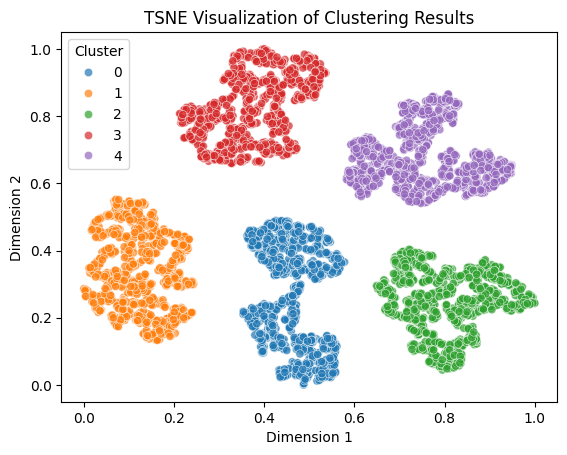

In [15]:
# ----------------------------------------------------------------------
# Models Estimation Example (default)
# ----------------------------------------------------------------------

# Set a random seed for reproducibility
SEED = 42

# Generate a sample dataset with blobs
X, _ = make_blobs(
    n_samples=5000,
    centers=5,
    cluster_std=0.4
)

# Initializing the class
clust_model_default = ClusteringModel(X_input=X)

# Select the best model
best_model_params, df_models_sorted = clust_model_default.select_best_model()

# Estimate the labels using the best model
labels = clust_model_default.estimate_best_model(best_params=best_model_params)

# Visualize the clusters in two dimensions
clust_model_default.visualize_reduced_data(labels=labels)
# ----------------------------------------------------------------------

----------------------------------------------------------------------
[14:38:49]: Models estimation started.
----------------------------------------------------------------------


Processing combinations: 32 models [00:13,  2.30 models/s]


----------------------------------------------------------------------
[14:39:03]: Models estimation finished.
----------------------------------------------------------------------
t-SNE algorithm fitted.
----------------------------------------------------------------------


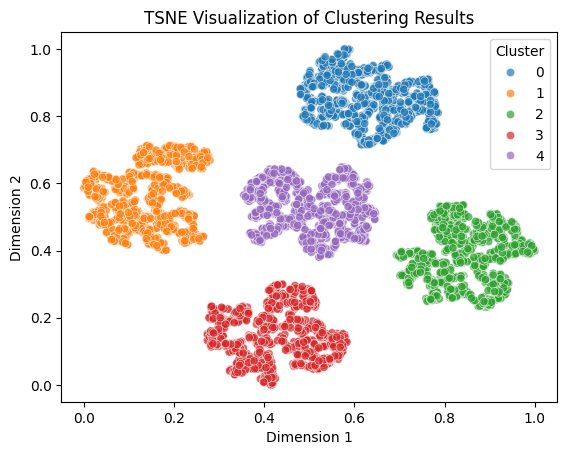

In [16]:
# ----------------------------------------------------------------------
# Models Estimation Example (with own Dicts)
# ----------------------------------------------------------------------

# Set a random seed for reproducibility
SEED = 42

# Generate a sample dataset with blobs
X, _ = make_blobs(
    n_samples=5000,
    centers=5,
    cluster_std=0.4
)

# Exclusion Dict (Optional)
exclusion_dict = {
    'scalers': ['StandardScaler'],
    'reducers': ['UMAP'],
    'models': ['KMeans']
}

# Parameters Dict (Optional)
params_dict = {
    'DBSCAN': {
        'eps': [round(i * 0.1, 1) for i in range(4, 6)],
        'min_samples': list(range(16, 32 * 2, 16))
    },
    'KMeans': {'n_clusters': list(range(2, 7))},
    'AgglomerativeClustering': {'n_clusters': list(range(2, 7))},
    'MeanShift': {'bandwidth': list(range(2, 7))},
    'FuzzyCMeans': {
        'n_clusters': list(range(2, 7)),
        'm': list(range(1, 4))
    }
}

# Initializing the class
clust_model_custom = ClusteringModel(
    X_input=X,
    exclude_dict=exclusion_dict,
    numerical_dict_params=params_dict,
)

# Select the best model
best_model_params, df_models_sorted = clust_model_custom.select_best_model()

# Estimate the labels using the best model
labels = clust_model_custom.estimate_best_model(best_params=best_model_params)

# Visualize the clusters in two dimensions
clust_model_custom.visualize_reduced_data(labels=labels)
# ----------------------------------------------------------------------

In [17]:
# ----------------------------------------------------------------------
# Models Estimation Example (with Categorical Data Models, Default)
# ----------------------------------------------------------------------

data = {
    'feature1': np.random.rand(1000) * 100,
    'feature2': np.random.rand(1000) * 100,
    'category1': np.random.choice(['A', 'B', 'C', 'D'], size=1000),
    'category2': np.random.choice(['X', 'Y', 'Z'], size=1000)
}
df = pd.DataFrame(data)

def get_pd_categorical_indices(df):
        """
        Given a DataFrame, extracts the indices of categorical columns.
        
        :param df: pandas DataFrame
        :return: list of indices of categorical columns
        """
        # Identify categorical columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        
        # Get the indices of categorical columns
        categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]
        
        return categorical_indices

# Get the indices of categorical columns
cat_indices = get_pd_categorical_indices(df)

# Convert DataFrame to a NumPy array
X = df.to_numpy()

# Initializing the class
clust_model_cat = ClusteringModel(
    X_input=X,
    use_categorical=True,
    categorical_cols=cat_indices
)

# Select the best model
best_model_params, df_models_sorted = clust_model_cat.select_best_model()

# Estimate the labels using the best model
labels = clust_model_cat.estimate_best_model(best_params=best_model_params)
# ----------------------------------------------------------------------

----------------------------------------------------------------------
[14:39:25]: Models estimation started.
----------------------------------------------------------------------


Processing combinations: 32 models [00:34,  1.07s/ models]

----------------------------------------------------------------------
[14:39:59]: Models estimation finished.
